In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import folium
import geojson
import xgboost as xgb
import pandas as pd
from shapely.geometry import shape
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

In [2]:
df_barnet = pd.read_csv(r'Data/barnet.csv')
lsoa_boundaries=gpd.read_file('Data/barnet.geojson')

df_house = pd.read_excel(r'Data/Copy of hou01tables2021.xlsx', sheet_name='7c')
df_house['lsoa11cd'] = df_house['Area Code']
del df_house['Area Code']

df_house['1 bedroom'] = df_house['1 bedroom'].replace('c', 0)
df_house['2 bedrooms'] = df_house['2 bedrooms'].replace('c', 0)
df_house['3 bedrooms'] = df_house['3 bedrooms'].replace('c', 0)
df_house['4 or more bedrooms'] = df_house['4 or more bedrooms'].replace('c', 0)
df_house['1bed'] = df_house['1 bedroom']/ (df_house['1 bedroom'] + df_house['2 bedrooms'] + df_house['3 bedrooms'] + df_house['4 or more bedrooms'])
df_house = df_house[['lsoa11cd', '1bed']]
df_house['percenrage of 1 bedroom'] = list(df_house['1bed'])

df_sunlight = pd.read_csv(r'sunlight_updated.csv')
df_sunlight['timestamp'] = df_sunlight['Year-Month'].apply(pd.Timestamp)
del df_sunlight['Year-Month']

select = ['E01000221', 'E01000223', 'E01000141', 'E01000184', 'E01000178', 'E01000176'] + list(df_barnet[(df_barnet['LSOA name'].str.contains('038')) | (df_barnet['LSOA name'].str.contains('029')) | (df_barnet['LSOA name'].str.contains('033')) | (df_barnet['LSOA name'].str.contains('035')) | (df_barnet['LSOA name'].str.contains('037')) | (df_barnet['LSOA name'].str.contains('040')) | (df_barnet['LSOA name'].str.contains('041'))]['lsoa11cd'].unique())
significant_lsoa = ['E01000138', 'E01000139', 'E01000145', 'E01000146', 'E01000211']

In [3]:
def calculate_lsoa_sizes(geojson_file):
    with open(geojson_file, 'r') as f:
        data = geojson.load(f)
        
    lsoa_sizes = []

    for feature in data['features']:
        lsoa_name = feature['properties']['lsoa11cd']
        lsoa_geometry = shape(feature['geometry'])
        lsoa_area = lsoa_geometry.area
        lsoa_sizes.append((lsoa_name, lsoa_area))

    return lsoa_sizes

lsoa_geojson_file = 'barnet.geojson'
sizes = calculate_lsoa_sizes(lsoa_geojson_file)

# Create a DataFrame from the sizes list
df_sizes = pd.DataFrame(sizes, columns=['lsoa11cd', 'Size'])

In [4]:
df_series = df_barnet.groupby(['lsoa11cd', 'date'])['Crime ID'].count().reset_index(name='Crime Count')

In [5]:
def display_points(df):
    m = folium.Map(location=[51.653544, 0.200264], zoom_start=4)

    # Add a marker for each location in the DataFrame
    for index, row in df.iterrows():
        folium.Marker(location=[row['Latitude'], row['Longitude']], 
                    popup=row['lsoa11cd']).add_to(m)
    return m

In [6]:
df_series['date'] = pd.to_datetime(df_series['date'], format='%Y-%m')
df_series['timestamp'] = df_series['date'] 
df_series.set_index('date', inplace=False)
df_series.set_index('date', inplace=True)
del df_series['timestamp']

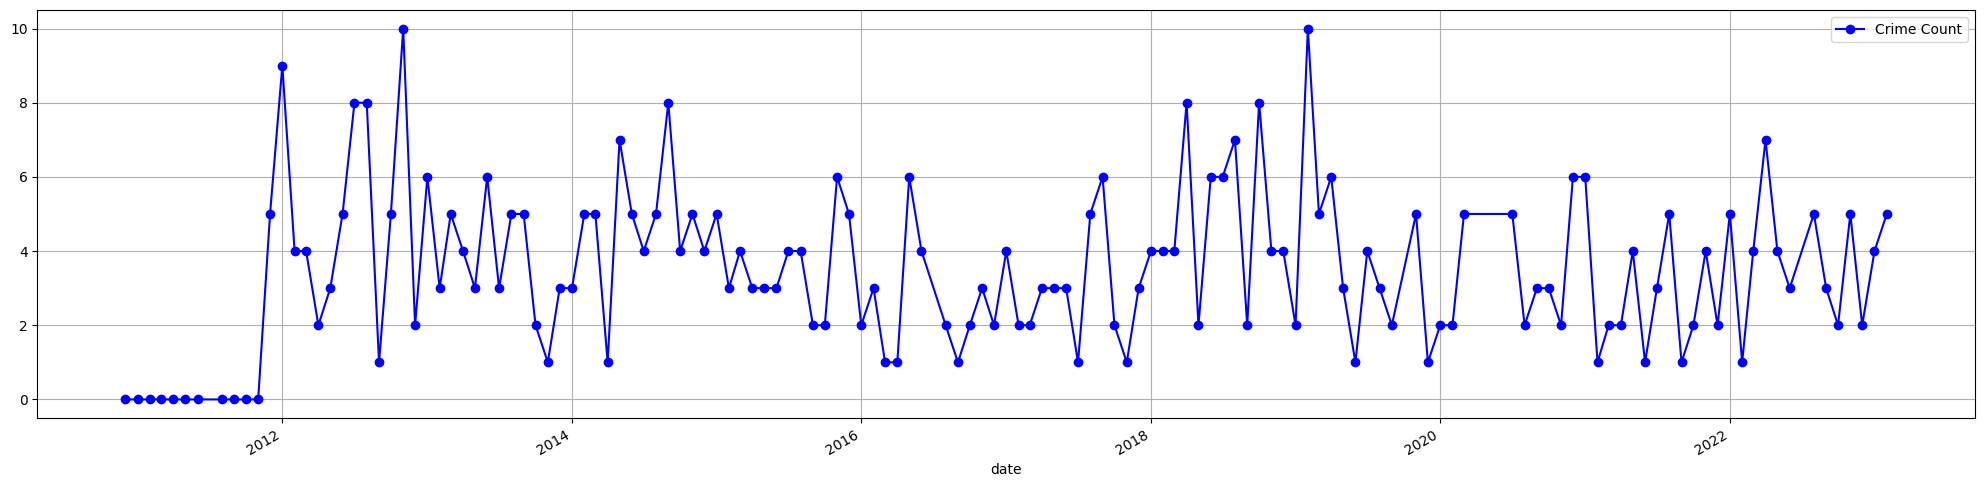

In [7]:
df_series[df_series['lsoa11cd']== 'E01000146'].plot(y='Crime Count', figsize=(25, 6), grid=True, marker='o', color='blue');

# 2012 - 2016 for Training, everything after is for testing

In [8]:
def create_features(df_series):
    df = df_series.copy()
    df['timestamp'] = df.index
    df = pd.merge(df, df_sunlight, on='timestamp', how='left')
    df['lag_1'] = df['Crime Count'].shift(1)
    df['lag_6'] = df['Crime Count'].shift(6)
    df['lag_12'] = df['Crime Count'].shift(12)
    df = pd.merge(df, df_sizes, on='lsoa11cd', how='left')
    df.set_index('timestamp', inplace=True)
    df = df.dropna()
    return df

In [9]:
df_series = create_features(df_series)

In [10]:

lsoa_dummies = pd.get_dummies(df_series['lsoa11cd'], prefix='lsoa')
df_for_pred = pd.concat([df_series, lsoa_dummies], axis=1)
df_for_pred['timestamp'] = df_for_pred.index
df_for_pred = pd.merge(df_for_pred, df_house[['lsoa11cd', 'percenrage of 1 bedroom']], on='lsoa11cd', how='left')
df_for_pred.set_index('timestamp', inplace=True)


In [11]:
df_training = df_for_pred[(df_for_pred.index > '2012-01-01') & (df_for_pred.index < '2017-01-01')]
df_testing = df_for_pred[df_for_pred.index >= '2017-01-01']

x_columns = df_for_pred.drop(['Crime Count', 'lsoa11cd'], axis=1).columns.tolist()

X_train, y_train = df_training[x_columns], df_training[['lsoa11cd', 'Crime Count']]
X_test, y_test = df_testing[x_columns], df_testing[['lsoa11cd', 'Crime Count']]

In [12]:
model = xgb.XGBRegressor(learning_rate=0.05, n_estimators=100, max_depth=3)

model.fit(X_train, y_train[['Crime Count']])

predictions = model.predict(X_test)

mse = mean_squared_error(y_test[['Crime Count']], predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test[['Crime Count']], predictions)
mse, mae

(1.4415622189620638, 0.926203634106252)

In [13]:
df_for_pred['percenrage of 1 bedroom'].corr(df_for_pred['Crime Count']), df_for_pred['Sunlight'].corr(df_for_pred['Crime Count'])

(0.07272602711015654, -0.07798994201789752)

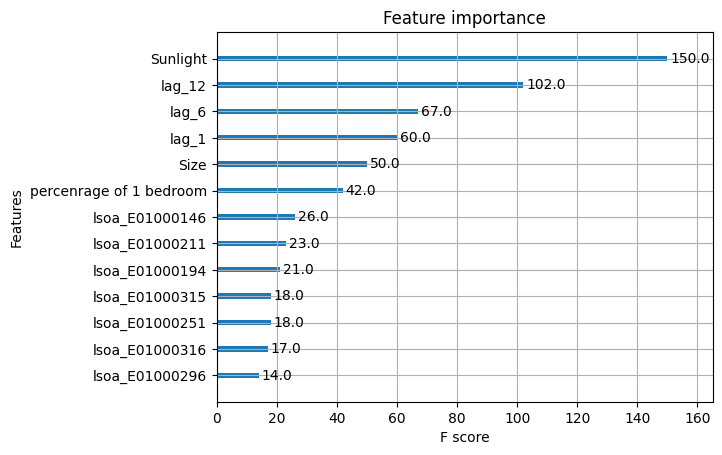

In [14]:
importance_dict = model.get_booster().get_score(importance_type='weight')

# Filter the features with an F score of 10 or higher
selected_features = {k: v for k, v in importance_dict.items() if v >= 10}

# Plot the filtered feature importance
xgb.plot_importance(selected_features, importance_type='weight')
plt.show()

In [15]:
y_test['Prediction'] = model.predict(X_test)
y_test['date'] = y_test.index.strftime('%Y-%m')
y_test['year'] = y_test.index.strftime('%Y')

/tmp/ipykernel_27290/2063507278.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test['Prediction'] = model.predict(X_test)
/tmp/ipykernel_27290/2063507278.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test['date'] = y_test.index.strftime('%Y-%m')
/tmp/ipykernel_27290/2063507278.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/

# Model Evaluation

In [16]:
y_valid = y_test[(y_test.index < '2020-01-01')]

In [17]:
def model_reg_eval(y_valid: pd.core.frame.DataFrame,
               comment: str):
    

    print(f'------{comment}------')
    # Mean Absolut Error
    mae = mean_absolute_error(y_valid['Crime Count'], y_valid['Prediction'])
    print("Mean Absolute Error (MAE):", mae)

    # Mean Absolute Percentage Error
    mape = np.mean(np.abs((y_valid['Crime Count'] - y_valid['Prediction']) / y_valid['Crime Count'])) * 100
    print("Mean Absolute Percentage Error (MAPE):", mape)

    # R-squared
    r2 = r2_score(y_valid['Crime Count'], y_valid['Prediction'])
    print("R-squared (R²):", r2)

    # Mean Forecast Error
    mfe = np.mean(y_valid['Crime Count'] - y_valid['Prediction'])
    print("Mean Forecast Error (MFE):", mfe)

    # Mean Absolute Scaled Error
    naive_error = np.mean(np.abs(y_valid['Crime Count'].diff()))
    mase = np.mean(np.abs(y_valid['Crime Count'] - y_valid['Prediction'])) / naive_error
    print("Mean Absolute Scaled Error (MASE):", mase)
    # print()

def get_crime_classes(df, column_name):

    # Define the cutoff quantiles
    quantiles = [0, 0.25, 0.50, 0.75, 1]

    # Calculate the quantile values
    cutoffs = df[column_name].quantile(quantiles).tolist()

    # Define the corresponding labels for each category
    labels = ['very low', 'low', 'average', 'high', 'very high']

    # Convert values to categories based on quantiles
    df['categories'] = pd.qcut(df[column_name], q=quantiles, labels=labels)

    # Optional: Remove the original column if not needed
    df = df.drop(column_name, axis=1)

    return df, cutoffs

In [18]:
model_reg_eval(y_valid[(y_valid['lsoa11cd'].isin(significant_lsoa)) & (y_valid.index < '2019-01-01')], 'Significant LSOAs for 2017-2018')
model_reg_eval(y_valid[(y_valid.index < '2019-01-01')], 'Whole barnet for 2017-2018')
model_reg_eval(y_valid[(y_valid['lsoa11cd'].isin(select)) & (y_valid.index < '2019-01-01')], 'South Barnet for 2017-2018')

------Significant LSOAs for 2017-2018------
Mean Absolute Error (MAE): 1.3095522074472337
Mean Absolute Percentage Error (MAPE): 59.43911751733074
R-squared (R²): 0.09236738750560514
Mean Forecast Error (MFE): 0.3265307960056123
Mean Absolute Scaled Error (MASE): 0.7782481689972132

------Whole barnet for 2017-2018------
Mean Absolute Error (MAE): 0.9527320886517735
Mean Absolute Percentage Error (MAPE): 59.72215108954191
R-squared (R²): 0.043807675632816956
Mean Forecast Error (MFE): -0.046651390341239794
Mean Absolute Scaled Error (MASE): 0.8264833537516124

------South Barnet for 2017-2018------
Mean Absolute Error (MAE): 1.0284963632884778
Mean Absolute Percentage Error (MAPE): 59.634705328698935
R-squared (R²): 0.08026057654522822
Mean Forecast Error (MFE): 0.05049757392782914
Mean Absolute Scaled Error (MASE): 0.8106217442740963



# Model Visualization

In [19]:
display_count = 'Crime Count'
lsoa_boundaries_selected = lsoa_boundaries.copy()

df_series_barnet = df_barnet.groupby(['lsoa11cd', 'date'])['Crime ID'].count().reset_index(name='Crime Count')
df_series_barnet['date'] = pd.to_datetime(df_series_barnet['date'])
df_series_barnet['year'] = df_series_barnet['date'].dt.year

lsoa_crime_counts = df_series_barnet.copy()[['lsoa11cd', 'Crime Count', 'year']]

lsoa_chosen = select

option_slctd = 2018

lsoa_crime_counts = lsoa_crime_counts.groupby(['lsoa11cd', 'year']).sum().reset_index()
lsoa_crime_counts = lsoa_crime_counts[lsoa_crime_counts['year'] == option_slctd]

lsoa_stats = lsoa_crime_counts[display_count].describe()

print(lsoa_stats)
custom_scale = [lsoa_stats['min'], lsoa_stats['25%'], lsoa_stats['50%'], 19, lsoa_stats['max']]

m = folium.Map(location=[51.6084, -0.2578], zoom_start=12.5)
folium.Choropleth(
    geo_data=lsoa_boundaries_selected,
    name='choropleth',
    data=lsoa_crime_counts,
    columns=['lsoa11cd', display_count],
    key_on='feature.properties.lsoa11cd',
    fill_color='YlOrRd',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name=f'{display_count}: {option_slctd}',
    highlight=True,
    tooltip=folium.features.GeoJsonTooltip(
        fields=['lsoa11cd', display_count],
        aliases=['LSOA Code', display_count],
        sticky=True,
        labels=True,
        style=("background-color: white; color: #333333; font-family: arial; font-size: 12px; padding: 10px;")
    )
    # threshold_scale=custom_scale
).add_to(m)

# Add lines between LSOA boundaries
lsoa_boundaries_layer = folium.GeoJson(
    lsoa_boundaries_selected,
    style_function=lambda feature: {
        'color': 'black',
        'weight': 2
    })
lsoa_boundaries_layer.add_to(m)
m

count    211.000000
mean      17.298578
std        8.079424
min        3.000000
25%       12.000000
50%       16.000000
75%       21.500000
max       59.000000
Name: Crime Count, dtype: float64
